### Initialize

In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
import torch
from networks import MLP
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
load_dir = '../manually_saved_runs/no_offset_ddpg_2/'
obs_size = 8
action_size = 2
max_action_offset = 1.0

In [4]:
device = torch.device(0)
device

device(type='cuda', index=0)

In [5]:
torch.manual_seed(3)

### Get experience buffer

In [6]:
exp_buffer = torch.load('../manually_saved_runs/no_offset_ddpg_2/exp_buffer.pt')
# entries are (s, a, r, s', done_flag) with |s|=8, |a|=2, |r|=1, |done_flag|=1

In [7]:
exp_buffer = torch.load(os.path.join(load_dir, "exp_buffer.pt"))
with open(os.path.join(load_dir, "exp_buffer_state.json"), "r") as fp:
    exp_buffer_state = json.load(fp)
    next_ind = exp_buffer_state["next_ind"]
    full = exp_buffer_state["full"]

In [8]:
exp_buffer

tensor([[ 0.0503, -0.0013, -0.1837,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0485, -0.0013, -0.1727,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0469, -0.0013, -0.1613,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.0561, -0.0013, -0.2226,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0541, -0.0013, -0.2093,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0521, -0.0013, -0.1952,  ...,  1.0000,  0.0000,  0.0000]])

In [9]:
# trim empty entries
exp_buffer = exp_buffer[:next_ind]
# randomly shuffle
exp_buffer = exp_buffer[torch.randperm(exp_buffer.size()[0])]

In [10]:
exp_buffer

tensor([[-2.1882e-02, -8.0869e-04, -3.5635e-05,  ...,  1.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-2.6642e-01,  7.5530e-01, -3.3576e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.7680e-02, -9.2321e-04,  3.7037e-02,  ...,  1.0000e+00,
          1.0000e+00,  0.0000e+00],
        ...,
        [ 1.1478e-01,  5.5291e-01, -1.7437e-01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.8942e-01,  4.5246e-02,  7.4961e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.7063e-01, -1.3334e-02, -2.9486e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

### Make dataset by hallucinating offsets

In [11]:
num_samples = exp_buffer.size()[0]
num_samples

117242

In [12]:
state, action, reward, next_state, done_mask = torch.split(
    exp_buffer, [obs_size, action_size, 1, obs_size, 1],
    dim=1
)

In [13]:
offsets = (torch.rand((num_samples,action_size)) - 0.5)
# above offsets are -0.5 to +0.5
offsets = offsets * max_action_offset/0.5
# now offsets are -max_action_offset to +max_action_offset

print(torch.min(offsets), torch.max(offsets))
action.size(), offsets.size()

tensor(-1.0000) tensor(1.0000)


(torch.Size([117242, 2]), torch.Size([117242, 2]))

In [14]:
hallucinated_actions = action - offsets
Y = offsets

In [15]:
hallucinated_buffer = torch.cat([state, hallucinated_actions, reward, next_state, done_mask], dim=1)
X = hallucinated_buffer

In [16]:
X.size(), Y.size()

(torch.Size([117242, 20]), torch.Size([117242, 2]))

### Make dataset splits

In [17]:
val_frac = 0.1
test_frac = 0.1
num_val = round(num_samples * val_frac)
num_test = round(num_samples * test_frac)
num_train = num_samples - num_val - num_test

X_train, X_val, X_test = torch.split(X, [num_train, num_val, num_test], dim=0)
Y_train, Y_val, Y_test = torch.split(Y, [num_train, num_val, num_test], dim=0)

In [18]:
print(X_train.size(), X_val.size(), X_test.size())
print(Y_train.size(), Y_val.size(), Y_test.size())

torch.Size([93794, 20]) torch.Size([11724, 20]) torch.Size([11724, 20])
torch.Size([93794, 2]) torch.Size([11724, 2]) torch.Size([11724, 2])


In [19]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [20]:
batch_size = 128
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

### Train MLP

In [21]:
# model = MLP([20,64,32,2]).to(device)
model = MLP([20,256,128,64,2]).to(device)
# model = MLP([20,256,128,64,2], lambda x: 0.5 * torch.tanh(x)).to(device)

In [22]:
epochs = 10000
learning_rate = 1e-3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
best_val_output_path = 'output/sas_to_offset_MLP_2_with_05_offset_bestval.pt'
best_val_output_path = 'output/sas_to_offset_MLP_2_with_1_offset_bestval.pt'

In [ ]:
best_val_loss = float('inf')

for epoch in range(epochs):  # loop over the dataset multiple times
    # print(f"epoch {epoch}")

    running_train_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...
            # print(f'iter {i+1:6}  train loss: {running_train_loss/1000}')
            running_train_loss = 0.0
    
    with torch.no_grad():
        running_val_loss = 0
        num_val_batches = 0
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            num_val_batches += 1

        val_loss = running_val_loss / num_val_batches
        # print(f"epoch {epoch} val MSE loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            print(f"epoch {epoch} val RMSE loss: {np.sqrt(val_loss):.6f} *")
            torch.save(model, best_val_output_path)
            best_val_loss = val_loss
        else:
            print(f"epoch {epoch} val RMSE loss: {np.sqrt(val_loss):.6f}")


In [24]:
# output model
# output_path = 'output/sas_to_offset_MLP_1.pt'
# torch.save(model, output_path)

### Evaluate the offset MLP

In [21]:
# loaded_model = torch.load(output_path).to(device)
# loaded_model = torch.load('output/sas_to_offset_MLP_2_with_05_offset_bestval.pt').to(device)
loaded_model = torch.load('output/sas_to_offset_MLP_2_with_1_offset_bestval.pt').to(device)

In [22]:
loaded_model

MLP(
  (net): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [23]:
Y_test[:10]

tensor([[-2.6429e-01, -1.2928e-02],
        [-4.2510e-01,  7.7735e-01],
        [ 3.7651e-01,  8.1682e-01],
        [ 7.5285e-01, -7.7689e-04],
        [ 3.0902e-01, -4.4900e-01],
        [-3.6678e-01, -4.4864e-01],
        [ 1.5505e-01, -5.1907e-01],
        [-8.6992e-01, -4.0859e-01],
        [-9.7624e-01, -9.9189e-01],
        [-7.8667e-01, -6.0155e-01]])

In [24]:
loaded_model(X_test[:10].to(device))

tensor([[-0.0090,  0.2218],
        [-0.2030,  0.6708],
        [ 0.0827,  0.8245],
        [ 0.0602,  0.2887],
        [ 0.5656, -0.3922],
        [-0.6734, -0.4720],
        [ 0.2009, -0.6001],
        [-0.7346, -0.2714],
        [-0.8615, -0.7053],
        [-0.5880, -0.6307]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [25]:
preds = loaded_model(X_test.to(device))
diffs = Y_test.to(device) - preds
diffs = diffs.detach().cpu()

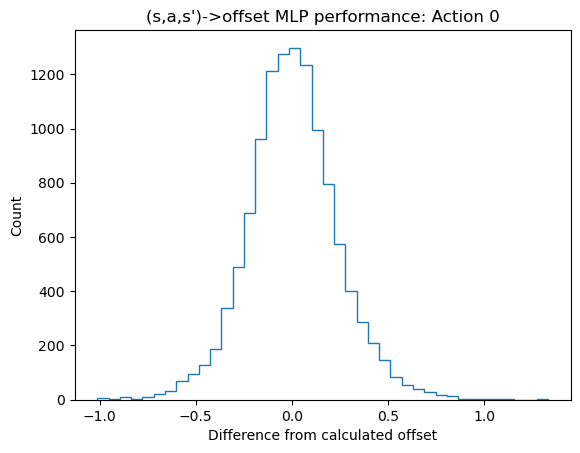

In [26]:
counts, bins = np.histogram(diffs[:,0], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("(s,a,s')->offset MLP performance: Action 0")
plt.show()

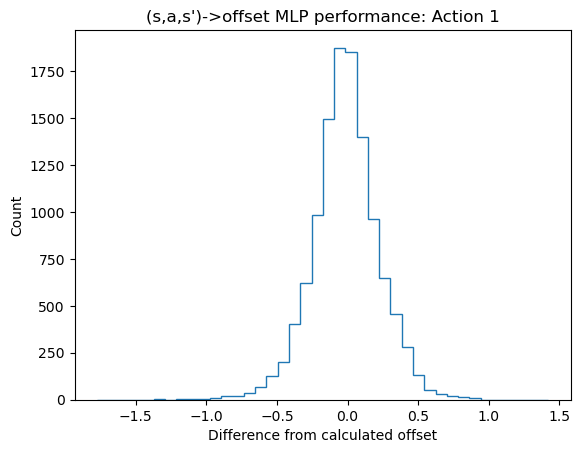

In [27]:
counts, bins = np.histogram(diffs[:,1], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("(s,a,s')->offset MLP performance: Action 1")
plt.show()

### Loss for different offset vals

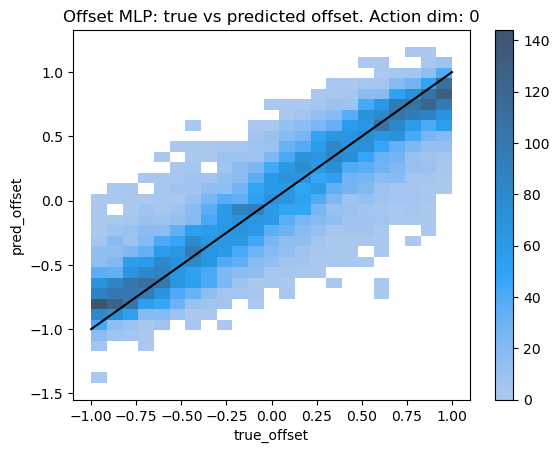

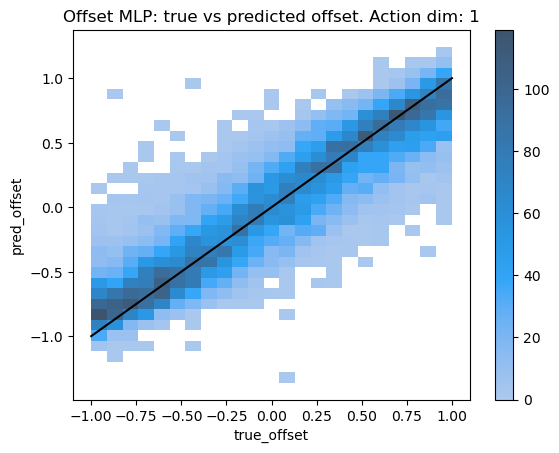

In [29]:
for i in range(2):
    df = pd.DataFrame(
        data = np.array([Y_test.numpy()[:,i],preds.detach().cpu().numpy()[:,i]]).T,
        columns = ['true_offset', 'pred_offset'],
    )

    plt.figure()
    plt.title(f'Offset MLP: true vs predicted offset. Action dim: {i}')
    sns.histplot(df, x="true_offset", y="pred_offset", cbar=True)
    plt.plot([-max_action_offset, max_action_offset], [-max_action_offset, max_action_offset], color='black')
    plt.show()

### Sanity checks

In [28]:
fake_preds = torch.zeros_like(Y_test)
# fake_preds = torch.rand_like(Y_test) - 0.5
fake_diffs = Y_test - fake_preds

In [29]:
print("Our network's test RMSE", torch.sqrt(torch.nn.functional.mse_loss(preds.detach().cpu(), Y_test)).item())
print("Fake predictions' test RMSE", torch.sqrt(torch.nn.functional.mse_loss(fake_preds, Y_test)).item())

Our network's test RMSE 0.18302175402641296
Fake predictions' test RMSE 0.28878629207611084


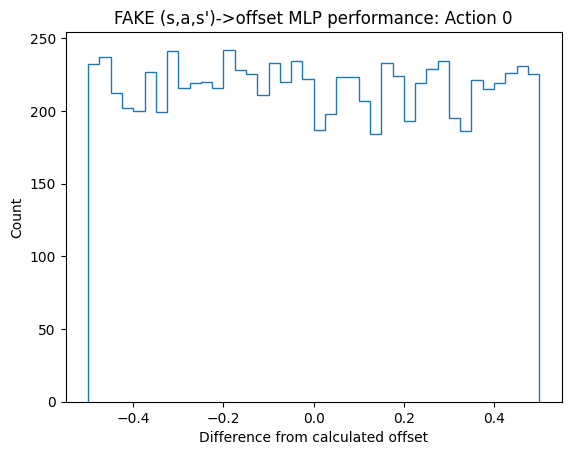

In [115]:
counts, bins = np.histogram(fake_diffs[:,0], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("FAKE (s,a,s')->offset MLP performance: Action 0")
plt.show()

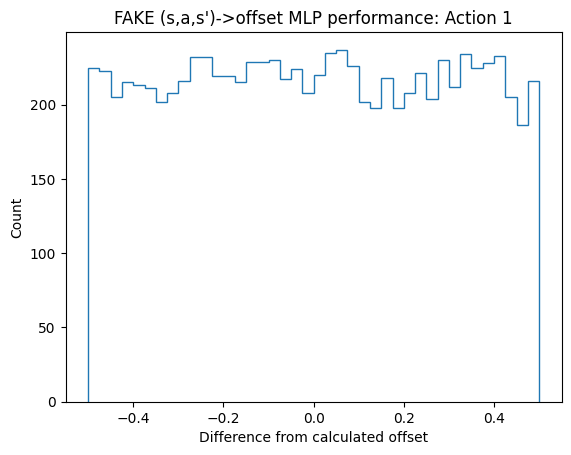

In [116]:
counts, bins = np.histogram(fake_diffs[:,1], bins=40)
plt.stairs(counts, bins)
plt.ylabel('Count')
plt.xlabel('Difference from calculated offset')
plt.title("FAKE (s,a,s')->offset MLP performance: Action 1")
plt.show()